In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install matplotlib==3.1.3

     |████████████████████████████████| 2.0 MB 7.7 MB/s 
     |████████████████████████████████| 88 kB 10.1 MB/s 
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 11.2 MB 49.5 MB/s 
     |████████████████████████████████| 930 kB 56.3 MB/s 
     |████████████████████████████████| 1.1 MB 53.4 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=822bfc7fa9198482e4bfb1674b1cefd05dfd7b263f1ca368f98276e32f008481
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=805c2ae219208151ae40989c8fa3456e80222f57cb2447fe489c0b2553f58adb
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for session-info: filename=session_info-1.0.0-py3-n

     |████████████████████████████████| 13.1 MB 9.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Pancreas_adata = sc.read_text("/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt", delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

In [4]:
PancreasMetadata = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [5]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

In [6]:
PancreasGenes = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

In [7]:
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [8]:
# Pancreas_adata.write(filename="/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_CellCycleRegressedOut_AnnData.h5ad")

In [9]:
cuda = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
from torch.nn.modules.activation import LeakyReLU

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.LeakyReLU = nn.LeakyReLU()
        self.FC_mean  = nn.Linear(input_dim, latent_dim)
        self.FC_var   = nn.Linear(input_dim, latent_dim)
        self.training = True 

    def forward(self, x):
        # x = self.LeakyReLU(x)
        mean = self.FC_mean(x)
        log_var = self.FC_var(x)
        return mean, log_var

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, latent_dim):
        super(Decoder, self).__init__()
        self.LeakyReLU = nn.LeakyReLU()
        self.linear = nn.Linear(latent_dim, output_dim)

    def forward(self, z):
        # x_hat = torch.sigmoid(self.LeakyReLU(self.linear(z)))
        x_hat = self.linear(z)
        return x_hat

In [12]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(output_dim, latent_dim)

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                            # reparameterization trick
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))   # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var, z

In [13]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [17]:
softmax = nn.Softmax(dim=0)

def train(autoencoder, data, NumCellTypes, optimizer, device, epochs=20):
    autoencoder.train()
    LossValues = []
    CellTypePredictions = []
    for cell in range(data.X.shape[0]):
      print('Cell: ' + str(cell+1))
      for epoch in range(epochs):
            x = torch.tensor(data.X[cell,:]).to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var, z = autoencoder(x)
            print(z)
            if epoch == epochs-1:
                CellTypePredictions.append(softmax(z).cpu().detach().numpy())
            loss = loss_function(x,x_hat,mean,log_var)
            LossValues.append(loss.item())
            loss.backward()
            optimizer.step()
            print('Epoch: ' + str(epoch+1))
    return autoencoder, CellTypePredictions, LossValues

In [18]:
NumPancreasCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())

autoencoder = VariationalAutoencoder(Pancreas_adata.shape[1], Pancreas_adata.shape[1], NumPancreasCellTypes)
autoencoder.to(device)

optimizer = Adam(autoencoder.parameters(), lr=1e-5)

autoencoder, PancreasCellProb, PancreasLoss = train(autoencoder, Pancreas_adata, NumPancreasCellTypes, optimizer, device, epochs=50)
PancreasLoss = np.stack(PancreasLoss)

Streaming output truncated to the last 5000 lines.
       device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9
tensor([114.1397,  -7.1102, 102.0133,  -4.6523,  78.0235,  78.8067,  19.6722,
        -71.8006, -19.5197,  10.7613,  23.9048, -49.3839,  15.5465,  -0.5841],
       device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10
tensor([  17.9929,  -21.2432,   79.3298,  -38.7660,    0.3963,  -15.8106,
        -271.7294, -119.5300,   15.1217,   15.8562,    2.3668,    3.0120,
          11.9407,   26.9293], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11
tensor([ -38.6101,  -45.1510,   12.3318,   96.1531, -126.8397,  -49.0412,
        -154.8867,   58.3655,  -27.6055,  -10.3868,   -3.3870,  -30.2018,
          12.0384,  -10.8778], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 12
tensor([  68.3698,  -11.8344,   -7.9547,   29.4460,  -44.5094,   21.3369,
        -161.2901,  -10.7317,  -56.7940,   28.8832,  -10.0021,  -78.0634,
          13.2792,    7.3208], device='cuda:0', grad_fn=<AddBackward0

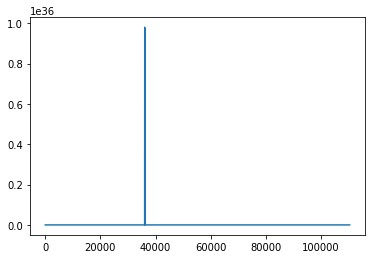

In [19]:
plt.plot(PancreasLoss)

In [20]:
PancreasLabels = []
for item in PancreasCellProb:
  PancreasLabels.append(str(np.where(item == max(item))[0][0]))

In [21]:
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=None)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


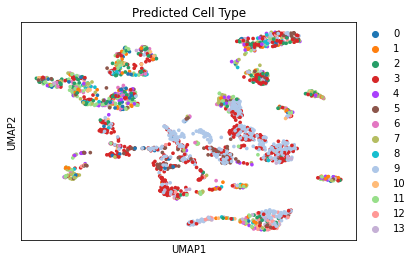

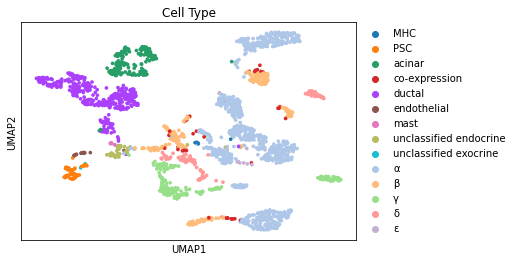

In [22]:
Pancreas_adata.obs['Predicted Cell Type'] = PancreasLabels

sc.pl.umap(Pancreas_adata, color=['Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

In [23]:
# Read and process GBM data 

GBM_adata = sc.read_text("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

GBMCellCycleScores = pd.read_table("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

GBM_Metadata = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

In [30]:
device = 'cpu'

In [31]:
NumGBMCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())
autoencoder_GBM = VariationalAutoencoder(GBM_adata.shape[1], GBM_adata.shape[1], NumGBMCellTypes)
autoencoder_GBM, GBM_CellProb, GBMLoss = train(autoencoder_GBM, GBM_adata, NumGBMCellTypes, optimizer, device, epochs=50)
GBM_Loss = np.stack(GBMLoss)

Streaming output truncated to the last 5000 lines.
         0.4234, -1.2018, -0.2131,  0.1302, -0.4906, -0.0851],
       grad_fn=<AddBackward0>)
Epoch: 15
tensor([ 2.3509,  0.3985,  3.6861, -0.4052, -0.7113, -0.3007, -1.0402, -1.0396,
         2.2492, -0.7603, -0.7007, -1.0001,  1.6890, -0.9546],
       grad_fn=<AddBackward0>)
Epoch: 16
tensor([-0.3008,  1.1414, -0.1215, -0.6243,  0.3904,  0.2248, -0.6306, -0.1078,
         1.3870,  1.1182,  0.4477, -0.1244,  1.9946, -0.0861],
       grad_fn=<AddBackward0>)
Epoch: 17
tensor([ 1.1180, -1.5897,  0.3101, -1.6699,  0.5045,  0.5397, -0.0163,  0.5742,
         0.6039, -1.1286,  0.7928,  1.9831,  1.1613,  0.4095],
       grad_fn=<AddBackward0>)
Epoch: 18
tensor([ 0.1418,  0.3417, -0.7786, -1.8466, -0.0063,  1.0013,  0.6208,  0.0709,
         2.2239, -1.1309, -0.2949,  1.2221,  0.9505, -0.8515],
       grad_fn=<AddBackward0>)
Epoch: 19
tensor([-0.3128, -0.1774,  1.5109, -0.0256, -0.5067,  0.4669, -0.0212, -0.4193,
         1.8093,  0.9367, -0.

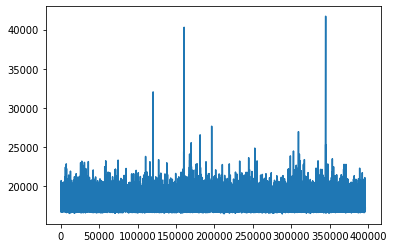

In [32]:
plt.plot(GBM_Loss)

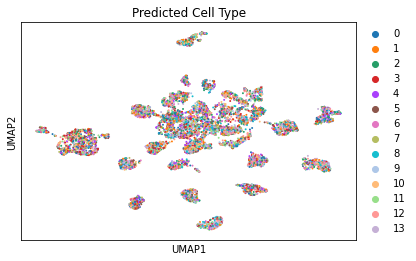

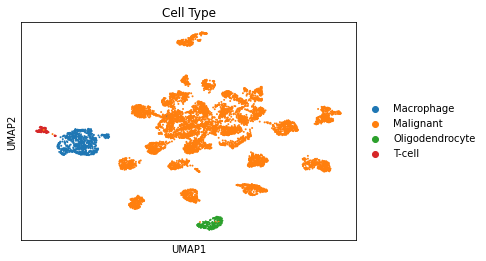

In [33]:
GBMLabels = []
for item in GBM_CellProb:
  GBMLabels.append(str(np.where(item == max(item))[0][0]))

GBM_adata.obs['Predicted Cell Type'] = GBMLabels

sc.tl.pca(GBM_adata, svd_solver='arpack')
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])